Загрузим нужные библиотеки

In [1]:
! python -m spacy download ru_core_news_sm

                                              0.0/15.3 MB ? eta -:--:--
                                             0.0/15.3 MB 991.0 kB/s eta 0:00:16
                                              0.1/15.3 MB 1.3 MB/s eta 0:00:12
                                              0.1/15.3 MB 1.0 MB/s eta 0:00:15
                                              0.2/15.3 MB 1.2 MB/s eta 0:00:13
                                              0.2/15.3 MB 1.1 MB/s eta 0:00:14
                                              0.3/15.3 MB 1.3 MB/s eta 0:00:12
                                              0.4/15.3 MB 1.3 MB/s eta 0:00:12
     -                                        0.5/15.3 MB 1.4 MB/s eta 0:00:11
     -                                        0.5/15.3 MB 1.5 MB/s eta 0:00:10
     -                                        0.6/15.3 MB 1.5 MB/s eta 0:00:10
     -                                        0.7/15.3 MB 1.6 MB/s eta 0:00:10
     --                                       0.8/15.3 MB 

In [2]:
import pandas as pd
import unicodedata
import re
import spacy
import json
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
import os
import json
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess

# Подготовка данных

Загрузим данные

In [3]:
data = pd.read_csv('csv\\full_df.csv', sep=';')
data.head(3)
data = data.drop(columns='Unnamed: 0', axis=1)

Отфильтруем тексты по количеству символов. Оставим только 100+.

In [4]:
data['text_len'] = data.loc[:, 'text'].apply(lambda x: len(x))
data_filtered_by_text_len = data.query('text_len > 100')
print(f'Количество постов с 100+ символами: {data_filtered_by_text_len.shape[0]}')
data_filtered_by_text_len.head(3)

Количество постов с 100+ символами: 8556


,status,url,text,likes,reposts,comments,text_len
0,Middle Software Engineer - Yandex,https://www.linkedin.com/in/michilegorov,Всем привет!Выпустил свою первую статью на хаб...,17.0,0.0,0.0,295
1,Middle Software Engineer - Yandex,https://www.linkedin.com/in/michilegorov,"Если вам интересно позалипать в слова, я запус...",6.0,0.0,2.0,117
2,Middle Software Engineer - Yandex,https://www.linkedin.com/in/michilegorov,"Если вам интересно позалипать в слова, я запус...",17.0,6.0,0.0,117


Оставим только тексты содержащие кириллицу

In [5]:
data_cyrillic = data_filtered_by_text_len[data_filtered_by_text_len['text'].apply(lambda x: re.match(r'[А-Яа-я]+', x) is not None)]

print(f'Текстов на кириллице: {data_cyrillic.shape[0]}')
data_cyrillic.head(3)

Текстов на кириллице: 1960


,status,url,text,likes,reposts,comments,text_len
0,Middle Software Engineer - Yandex,https://www.linkedin.com/in/michilegorov,Всем привет!Выпустил свою первую статью на хаб...,17.0,0.0,0.0,295
1,Middle Software Engineer - Yandex,https://www.linkedin.com/in/michilegorov,"Если вам интересно позалипать в слова, я запус...",6.0,0.0,2.0,117
2,Middle Software Engineer - Yandex,https://www.linkedin.com/in/michilegorov,"Если вам интересно позалипать в слова, я запус...",17.0,6.0,0.0,117


Удалим дубликаты текстов

In [6]:
data_dd = data_cyrillic.drop_duplicates('text')
print(f'Осталось {data_dd.shape[0]} строк')
data_dd.head(3)

Осталось 1862 строк


,status,url,text,likes,reposts,comments,text_len
0,Middle Software Engineer - Yandex,https://www.linkedin.com/in/michilegorov,Всем привет!Выпустил свою первую статью на хаб...,17.0,0.0,0.0,295
1,Middle Software Engineer - Yandex,https://www.linkedin.com/in/michilegorov,"Если вам интересно позалипать в слова, я запус...",6.0,0.0,2.0,117
6,Talent Acquisition Manager | Recruitment Lead ...,https://www.linkedin.com/in/dariaivanova,С трепетом готов представить свой продукт. Реф...,8.0,0.0,0.0,841


In [7]:
# Список слов для фильтрации
words = ['наставничество', 'наставник', 'ментор', 'коуч', 'mentorship', 'mentor', 'coaching', 'buddy']

# Фильтрация строк, содержащих хотя бы одно слово из списка
filtered_df = data_dd[data_dd['text'].str.contains('|'.join(words), case=False, regex=True)]

# Подготовка к моделированию

In [8]:
texts = filtered_df["text"].tolist()
texts[0]

'Пришли в гости к Vadim Nareyko, партнеру EnCata - Engineering CATALYST, развивающему направление EnCata Soft (разработка софта для стартапов). Вадим - основатель Школы Управленческого Мастерства, Ментор года (2015), стартапер, сертифицированный Scrum Master. Говорили об управлении проектами в IT, о программировании и зарплатах разработчиков в 90е, бережливом производстве, подготовке и обучении менеджеров, развитии управленца, стартапах, о том, как попасть в акселератор Startup Wise Guys и многом другом. И, конечно, ТОП-5 советов стартапам за 2 минуты. Прогулялись по производству EnCata, где создают MVP для стартапов, спустились в бункер хакспейса MakeIT Center, где любой человек без подготовки через 2 дня обучения может заниматься лазерной резкой за $1 в час.https://lnkd.in/gREubTP #encata #бережливоепроизводство #управлениепроектами #itшахта'

Проведем лемматизацию

In [9]:
if os.path.exists('lemmas.json'):
    with open("lemmas.json") as f:
        data_lemmatized = json.load(f)['lemmas']
else:
    model = spacy.load('ru_core_news_sm', disable=['ner', 'parser'])
    data_lemmatized = []
    for doc in model.pipe(texts, disable=["tagger", "parser"]):
        data_lemmatized.append([token.lemma_ for token in doc])

    with open("lemmas.json", "w") as fid:
        json.dump({"lemmas": data_lemmatized}, fid)

print(data_lemmatized[0])

['прийти', 'в', 'гость', 'к', 'vadim', 'nareyko', ',', 'партнёр', 'encata', '-', 'engineering', 'catalyst', ',', 'развивающему', 'направление', 'encata', 'soft', '(', 'разработка', 'софт', 'для', 'стартап', ')', '.', 'вадим', '-', 'основатель', 'школа', 'управленческий', 'мастерство', ',', 'ментор', 'год', '(', '2015', ')', ',', 'стартапер', ',', 'сертифицировать', 'scrum', 'master', '.', 'говорить', 'об', 'управление', 'проект', 'в', 'it', ',', 'о', 'программирование', 'и', 'зарплата', 'разработчик', 'в', '90е', ',', 'бережливый', 'производство', ',', 'подготовка', 'и', 'обучение', 'менеджер', ',', 'развитие', 'управленец', ',', 'стартап', ',', 'о', 'том', ',', 'как', 'попасть', 'в', 'акселератор', 'startup', 'wise', 'guys', 'и', 'многом', 'друг', '.', 'и', ',', 'конечно', ',', 'топ-5', 'совет', 'стартап', 'за', '2', 'минута', '.', 'прогулялись', 'по', 'производство', 'encata', ',', 'где', 'создавать', 'mvp', 'для', 'стартап', ',', 'спуститься', 'в', 'бункер', 'хакспейса', 'makeit', '

Очистим тексты от ненужных символов

In [10]:
word_pattern = re.compile("^[а-я]*$")

def remove_symbols(doc):
    return [token for token in doc if word_pattern.match(token)]

data_words = list(map(remove_symbols, data_lemmatized))
print(data_words[0])

['прийти', 'в', 'гость', 'к', 'развивающему', 'направление', 'разработка', 'софт', 'для', 'стартап', 'вадим', 'основатель', 'школа', 'управленческий', 'мастерство', 'ментор', 'год', 'стартапер', 'сертифицировать', 'говорить', 'об', 'управление', 'проект', 'в', 'о', 'программирование', 'и', 'зарплата', 'разработчик', 'в', 'бережливый', 'производство', 'подготовка', 'и', 'обучение', 'менеджер', 'развитие', 'управленец', 'стартап', 'о', 'том', 'как', 'попасть', 'в', 'акселератор', 'и', 'многом', 'друг', 'и', 'конечно', 'совет', 'стартап', 'за', 'минута', 'прогулялись', 'по', 'производство', 'где', 'создавать', 'для', 'стартап', 'спуститься', 'в', 'бункер', 'хакспейса', 'где', 'любой', 'человек', 'без', 'подготовка', 'через', 'день', 'обучение', 'мочь', 'заниматься', 'лазерный', 'резка', 'за', 'в', 'бережливоепроизводство', 'управлениепроектами']


Загрузим русские стоп-слова

In [11]:
stop_words = stopwords.words('russian')
stop_words += ['это', 'свой', 'очень', 'мочь', 'ваш', 'наш']

Определим функцию для удаления стоп-слов

In [12]:
def remove_stopwords(texts):
    return [[word for word in doc if word not in stop_words] for doc in texts]

Применим функцию для удаления стоп-слов

In [13]:
data_words_nostops = remove_stopwords(data_words)

In [14]:
id2word = corpora.Dictionary(data_words_nostops)

texts = data_words_nostops

corpus = [id2word.doc2bow(text) for text in texts]

In [15]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('акселератор', 1),
  ('бережливоепроизводство', 1),
  ('бережливый', 1),
  ('бункер', 1),
  ('вадим', 1),
  ('говорить', 1),
  ('год', 1),
  ('гость', 1),
  ('день', 1),
  ('друг', 1),
  ('заниматься', 1),
  ('зарплата', 1),
  ('лазерный', 1),
  ('любой', 1),
  ('мастерство', 1),
  ('менеджер', 1),
  ('ментор', 1),
  ('минута', 1),
  ('многом', 1),
  ('направление', 1),
  ('обучение', 2),
  ('основатель', 1),
  ('подготовка', 2),
  ('попасть', 1),
  ('прийти', 1),
  ('программирование', 1),
  ('прогулялись', 1),
  ('проект', 1),
  ('производство', 2),
  ('развивающему', 1),
  ('развитие', 1),
  ('разработка', 1),
  ('разработчик', 1),
  ('резка', 1),
  ('сертифицировать', 1),
  ('совет', 1),
  ('создавать', 1),
  ('софт', 1),
  ('спуститься', 1),
  ('стартап', 4),
  ('стартапер', 1),
  ('управленец', 1),
  ('управление', 1),
  ('управлениепроектами', 1),
  ('управленческий', 1),
  ('хакспейса', 1),
  ('человек', 1),
  ('школа', 1)]]

# Протестируем моделирование с 20 темами

In [16]:
lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=20, 
    random_state=100,
    update_every=1,
    chunksize=100,
    passes=10,
    alpha='auto',
    per_word_topics=True
    )

In [17]:
lda_model.print_topics()

[(0,
  '0.018*"опыт" + 0.015*"работа" + 0.013*"интересный" + 0.010*"получить" + 0.008*"готовый" + 0.008*"заказчик" + 0.008*"заказ" + 0.008*"думать" + 0.008*"разный" + 0.008*"стать"'),
 (1,
  '0.011*"сложный" + 0.011*"идея" + 0.008*"работа" + 0.008*"собственный" + 0.008*"персональный" + 0.008*"работать" + 0.008*"приходиться" + 0.008*"коллега" + 0.008*"начать" + 0.008*"фриланс"'),
 (2,
  '0.011*"каждый" + 0.011*"веб" + 0.011*"разработка" + 0.011*"микросервисы" + 0.011*"цель" + 0.006*"год" + 0.006*"компания" + 0.006*"ментор" + 0.006*"пройти" + 0.006*"направление"'),
 (3,
  '0.008*"стартанули" + 0.008*"обучениеснуля" + 0.008*"взаимодействовать" + 0.008*"количество" + 0.008*"погнать" + 0.008*"промежуточный" + 0.008*"эффективно" + 0.008*"текущий" + 0.008*"отметить" + 0.008*"подразделениямиактуальное"'),
 (4,
  '0.031*"анкета" + 0.017*"стажировка" + 0.010*"каждый" + 0.010*"задание" + 0.010*"тестовый" + 0.010*"обучение" + 0.010*"кандидат" + 0.007*"год" + 0.007*"срок" + 0.007*"тебе"'),
 (5,
  '

Вычислим сложность и согласованность модели

In [18]:
print('Perplexity: ', lda_model.log_perplexity(corpus))

coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Perplexity:  -7.872954306282036
Coherence Score:  0.40444603027286374


Отобразим результаты моделирования

In [19]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
15    -0.109082  0.000469       1        1  17.883452
19    -0.105038  0.006627       2        1  10.015554
17    -0.121662  0.074445       3        1   8.912048
5     -0.119707  0.073344       4        1   8.806366
12     0.085738  0.146228       5        1   7.000883
6      0.018373 -0.188675       6        1   6.276665
13    -0.081291 -0.031490       7        1   5.120770
16    -0.047539 -0.095213       8        1   5.081734
0     -0.025827 -0.009394       9        1   4.796872
18     0.028649  0.046487      10        1   4.396692
14     0.053669  0.005173      11        1   3.421756
4      0.064437  0.007716      12        1   3.031308
11     0.095558  0.026672      13        1   2.928788
1      0.030048  0.006512      14        1   2.636221
8      0.030136  0.014389      15        1   2.370096
10     0.009516 -0.030557      16        1   2.315786
9      0.050455 -0.055731      17        1   2.289286
7      0.042172  0.005329      18        1   1.360477
2      0.042037  0.004825      19        1   1.065366
3      0.059358 -0.007156      20        1   0.289881, topic_info=            Term       Freq      Total Category  logprob  loglift
245         опыт  28.000000  28.000000  Default  30.0000  30.0000
570     компания  20.000000  20.000000  Default  29.0000  29.0000
1172   портфолио   6.000000   6.000000  Default  28.0000  28.0000
671        время  25.000000  25.000000  Default  27.0000  27.0000
382         цель  14.000000  14.000000  Default  26.0000  26.0000
...          ...        ...        ...      ...      ...      ...
496     успешный   0.008241   4.031810  Topic20  -7.6201  -0.3494
871      занятие   0.007865   5.248379  Topic20  -7.6668  -0.6598
42    управление   0.007897  11.149824  Topic20  -7.6628  -1.4093
152       почему   0.007820   9.777412  Topic20  -7.6726  -1.2877
283        новый   0.007813  24.525338  Topic20  -7.6734  -2.2082

[1222 rows x 6 columns], token_table=      Topic      Freq                Term
term                                     
738      15  0.857852           абсолютно
2059     13  0.819408            авантюра
728       4  0.693964       автоматизация
1567      6  0.718592  автоматизированный
601      13  0.819209               агент
...     ...       ...                 ...
232       8  0.427438                эфир
232      11  0.213719                эфир
357      15  0.858492             эффекте
500       6  0.656285          эффективно
1473      4  0.887687       эффективность

[1976 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[16, 20, 18, 6, 13, 7, 14, 17, 1, 19, 15, 5, 12, 2, 9, 11, 10, 8, 3, 4])

# Подбор количества тем

Подберем количество тем основываясь на согласованности модели

In [20]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(
            corpus=corpus,
            id2word=id2word,
            num_topics=num_topics, 
            random_state=765,
            update_every=1,
            chunksize=100,
            passes=10,
            alpha='auto',
            per_word_topics=True
            )
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [21]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_words_nostops, start=1, limit=20, step=1)

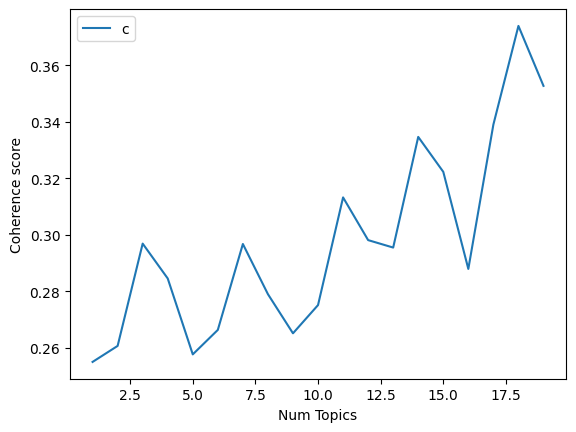

In [22]:
limit=20
start=1
step=1
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

Наилучший результат показала модель с 13 темами

In [23]:
def model_scorer(data):
    id2word = corpora.Dictionary(data)

    texts = data

    corpus = [id2word.doc2bow(text) for text in texts]

    lda_model = gensim.models.ldamodel.LdaModel(
        corpus=corpus,
        id2word=id2word,
        num_topics=13, 
        random_state=765,
        update_every=1,
        chunksize=100,
        passes=10,
        alpha='auto',
        per_word_topics=True
        )

    print('Perplexity: ', lda_model.log_perplexity(corpus))

    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('Coherence Score: ', coherence_lda)

    return lda_model, corpus, id2word

best_model, best_corpus, best_id2word = model_scorer(data_words_nostops)

Perplexity:  -7.809327739083289
Coherence Score:  0.29544012748804954


# Использование биграмм и триграмм

Проверим, повлияет ли использование биграмм и триграмм на согласованность модели

In [24]:
bigram = gensim.models.Phrases(data_words_nostops, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words_nostops], threshold=100)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [25]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

data_words_bigrams = make_bigrams(data_words_nostops)
data_words_trigrams = make_trigrams(data_words_nostops)

In [26]:
model_scorer(data_words_bigrams)
print('Complete')

Perplexity:  -7.818608678493887
Coherence Score:  0.30609542159951075
Complete


In [27]:
model_scorer(data_words_trigrams)
print('Complete')

Perplexity:  -7.818608678493887


Использование биграмм и триграмм только ухудшили согласованнось

# Анализ наилучшей модели

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(best_model, best_corpus, best_id2word)
vis

In [ ]:
topic_probs = best_model.get_document_topics(best_corpus)
max_prob_topics = list(map(lambda doc_probs: max(doc_probs, key=lambda x: x[1])[0], topic_probs))

In [ ]:
df = pd.DataFrame([list(data_dd["text"]), max_prob_topics]).transpose()
df.columns = ['text', 'topic_label']
df.head(3)

In [ ]:
df.loc[df['topic_label'] == 1].head()

# Вывод

С имеющимися данными наилучшую согласованность имеет модель с разделением на 13 тем. Выведем топ слов по каждой теме.

In [ ]:
N_TOPICS = 13
for i in range(N_TOPICS):
    print("Тема",i+1, ":")
    print(best_model.show_topic(i))